In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.models import resnet50
from scipy import stats
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from suitability.datasets.dollarstreet import DollarStreetDataset, get_dollarstreet
from suitability.filter.sample_signals import ConfidenceSignal, DecisionBoundarySignal, TrainingDynamicsSignal
from suitability.filter.tests import t_test, non_inferiority_test, equivalence_test

random.seed(32)
np.random.seed(32)

### Calculate Signals

In [8]:
# Specify dataset path
root_dir = '/mfsnic/u/apouget/data/dollarstreet/dataset_dollarstreet/'

# Load model
model = resnet50(weights=None)
state_dict = torch.load('/mfsnic/u/apouget/experiments/dollarstreet/best_model.pth')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Determine data splits
REGIONS = ['eu', 'am', 'as', 'af']

# Construct suitability filter
confidences = {}
decision_boundaries = {}
training_dynamics = {}
correctness = {}

td_checkpoints = [
    '/mfsnic/u/apouget/experiments/dollarstreet/model_epoch_10.pth',
    '/mfsnic/u/apouget/experiments/dollarstreet/model_epoch_20.pth',
    '/mfsnic/u/apouget/experiments/dollarstreet/model_epoch_30.pth',
    '/mfsnic/u/apouget/experiments/dollarstreet/model_epoch_40.pth',
    '/mfsnic/u/apouget/experiments/dollarstreet/model_epoch_50.pth',
    '/mfsnic/u/apouget/experiments/dollarstreet/model_epoch_60.pth',
    '/mfsnic/u/apouget/experiments/dollarstreet/model_epoch_70.pth',
    '/mfsnic/u/apouget/experiments/dollarstreet/model_epoch_80.pth',
    '/mfsnic/u/apouget/experiments/dollarstreet/last_model.pth',
]

for region in REGIONS:
    model.load_state_dict(state_dict)
    model.to(device)
    data = get_dollarstreet(root_dir, 'test', batch_size=64, shuffle=False, num_workers=4, pre_filter=lambda x: x['region.id'] == region)

    signal = ConfidenceSignal(model, data, device)
    conf, corr = signal.evaluate()
    confidences[region] = conf
    correctness[region] = corr

    signal = DecisionBoundarySignal(model, data, device, max_steps=150, metric='l1', perturbation=0.01)
    db = signal.evaluate()
    decision_boundaries[region] = db

    signal = TrainingDynamicsSignal(model, data, device, td_checkpoints)
    td = signal.evaluate()
    training_dynamics[region] = td
    
    print(f'Region {region}: {np.mean(correctness[region]) * 100:.2f}% correct')

Region eu: 35.28% correct
Region am: 33.64% correct
Region as: 30.54% correct
Region af: 28.93% correct


### Statistical Testing

In [11]:
test_fn = non_inferiority_test

for region in ['am', 'as', 'af']:
    print(f'EU vs {region} confidences:', test_fn(confidences['eu'], confidences[region]))
    print(f'EU vs {region} decision boundaries:', test_fn(decision_boundaries['eu'], decision_boundaries[region]))
    print(f'EU vs {region} training dynamics:', test_fn(training_dynamics['eu'], training_dynamics[region]))

EU vs am confidences: (1.0316236945381057, 0.1512106124211776)
EU vs am decision boundaries: (0.5211316154725855, 0.30117865782247977)
EU vs am training dynamics: (0.8801539569357302, 0.18946115819177156)
EU vs as confidences: (2.6032634066614935, 0.004675051847781061)
EU vs as decision boundaries: (-2.340771159724176, 0.0096978117040404)
EU vs as training dynamics: (0.017031926126539743, 0.493206976035356)
EU vs af confidences: (3.380387254967134, 0.0003716622343081908)
EU vs af decision boundaries: (-2.5480074507134836, 0.005466244726858462)
EU vs af training dynamics: (-1.4777739586656833, 0.06984173792381115)


In [13]:
# Function to perform t-tests and calculate accuracy for different sample sizes
def run_tests_for_samples(signals, correctness, sample_sizes, test_fn):
    results = []
    
    for sample_size in sample_sizes:
        row = {'sample_size': sample_size}
        for region in ['am', 'as', 'af']:
            # Sample from the confidence scores and correctness of the region
            sampled_indices = random.sample(range(len(signals[region])), min(sample_size, len(signals[region])))
            sampled_signals = [signals[region][i] for i in sampled_indices]
            sampled_correctness = [correctness[region][i] for i in sampled_indices]
            
            # Perform t-test between EU and the sampled region
            t_stat, p_val = test_fn(signals['eu'], sampled_signals, equal_var=False)
            row[f'p-value eu vs {region}'] = p_val
            row[f't-statistic eu vs {region}'] = t_stat
            
            # Calculate accuracy of the sampled region
            sampled_accuracy = np.mean(sampled_correctness) * 100  # Accuracy in percentage
            row[f'accuracy {region}'] = sampled_accuracy
        
        results.append(row)

    return pd.DataFrame(results)

# Sample sizes to test
sample_sizes = [5, 10, 50, 100, 150, 200, 300, 400, 500, 600, 700, 800]

# Assuming the `signals` and `correctness` dictionaries already contain the data for each region
df_conf = run_tests_for_samples(confidences, correctness, sample_sizes, test_fn)
df_db = run_tests_for_samples(decision_boundaries, correctness, sample_sizes, test_fn)

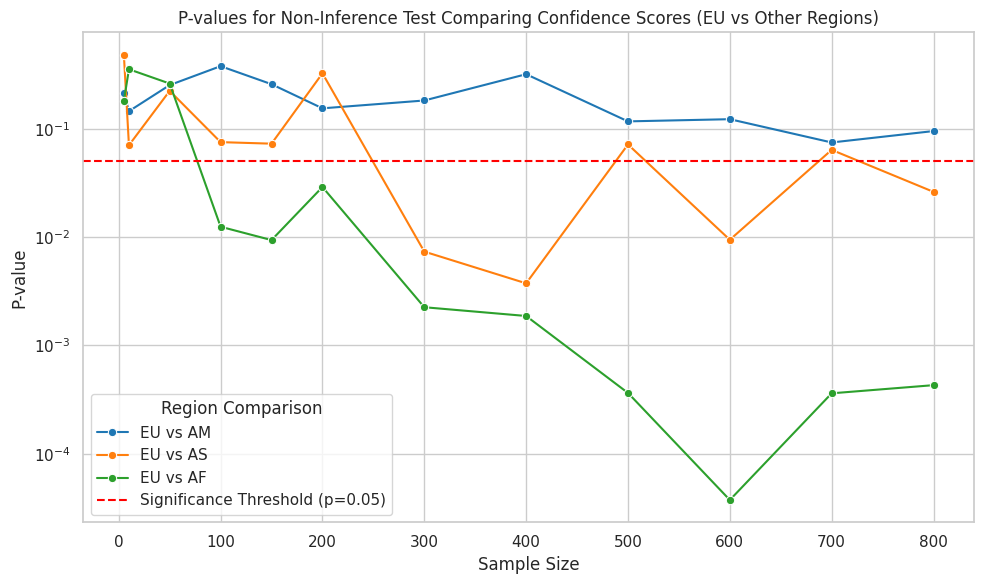

In [22]:
df = df_conf
name = "Confidence"

# Set the style for the plot
sns.set_theme(style="whitegrid")

# Melt the DataFrame for easier plotting with seaborn
df_melted = df.melt(id_vars='sample_size', value_vars=['p-value eu vs am', 'p-value eu vs as', 'p-value eu vs af'],
                    var_name='Comparison', value_name='p-value')

# Rename columns for better readability in the plot
df_melted['Comparison'] = df_melted['Comparison'].replace({
    'p-value eu vs am': 'EU vs AM',
    'p-value eu vs as': 'EU vs AS',
    'p-value eu vs af': 'EU vs AF'
})

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melted, x='sample_size', y='p-value', hue='Comparison', marker='o', palette='tab10')

# Highlight significance threshold (e.g., p < 0.05)
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')

# Customize the plot
plt.title(f'P-values for Non-Inference Test Comparing {name} Scores (EU vs Other Regions)')
plt.xlabel('Sample Size')
plt.ylabel('P-value')
plt.yscale('log')  # Optional: Use logarithmic scale for p-values
plt.legend(title='Region Comparison')
plt.tight_layout()

# Show the plot
plt.show()


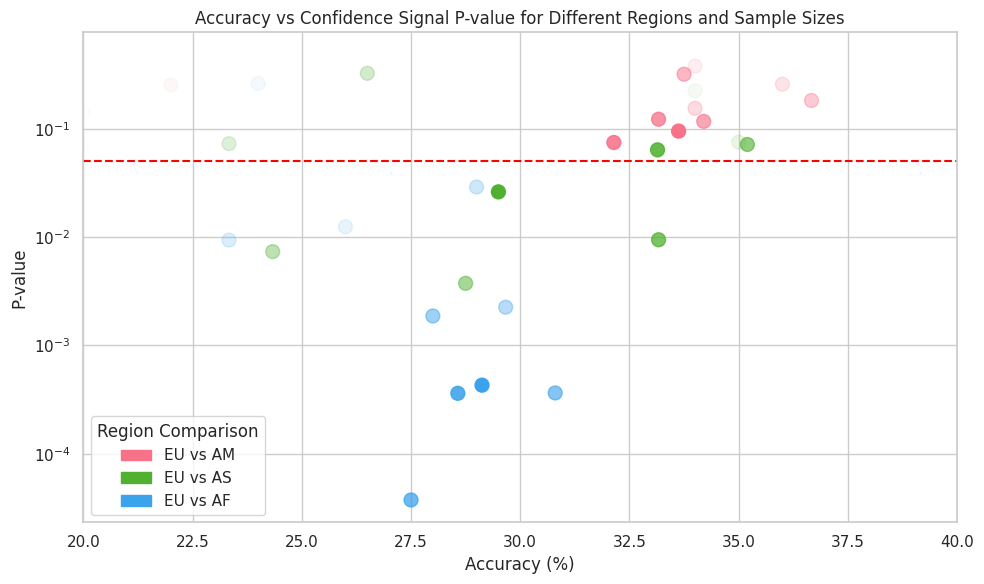

In [26]:
# Prepare the data for plotting
df_melted = df.melt(id_vars='sample_size', 
                    value_vars=['p-value eu vs am', 'p-value eu vs as', 'p-value eu vs af',
                                'accuracy am', 'accuracy as', 'accuracy af'], 
                    var_name='Metric', value_name='Value')

# Extract region and metric type (p-value or accuracy)
df_melted['Region'] = df_melted['Metric'].apply(lambda x: x.split()[-1])  # Get the region (am, as, af)
df_melted['Metric'] = df_melted['Metric'].apply(lambda x: ' '.join(x.split()[:-1]))  # Get metric (p-value or accuracy)

# Pivot the DataFrame to get separate columns for accuracy and p-values
df_plot = df_melted.pivot_table(index=['sample_size', 'Region'], columns='Metric', values='Value').reset_index()

# Normalize the sample size to create a brightness scale for colors
norm = plt.Normalize(df_plot['sample_size'].min(), df_plot['sample_size'].max())

# Set up the color palette
palette = sns.color_palette("husl", 3)  # A color palette with 3 distinct colors for am, as, af
region_colors = {'am': palette[0], 'as': palette[1], 'af': palette[2]}

# Plotting
plt.figure(figsize=(10, 6))
for region in ['am', 'as', 'af']:
    subset = df_plot[df_plot['Region'] == region]
    plt.scatter(subset['accuracy'], subset[f'p-value eu vs'], 
                c=[region_colors[region]] * len(subset), 
                s=100,  # Marker size
                alpha=norm(subset['sample_size']),  # Brighter color for larger sample sizes
                label=f'EU vs {region.upper()}')

# Highlight significance threshold (e.g., p < 0.05)
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')

legend_handles = [
    mpatches.Patch(color=region_colors['am'], label='EU vs AM'),
    mpatches.Patch(color=region_colors['as'], label='EU vs AS'),
    mpatches.Patch(color=region_colors['af'], label='EU vs AF')
]

# Customize the plot
plt.title(f'Accuracy vs {name} Signal P-value for Different Regions and Sample Sizes')
plt.xlabel('Accuracy (%)')
plt.ylabel('P-value')
plt.xlim(20,40)
plt.yscale('log')  # Optional: Log scale for p-values for better visibility
plt.legend(handles=legend_handles, title='Region Comparison')
plt.tight_layout()

# Show the plot
plt.show()


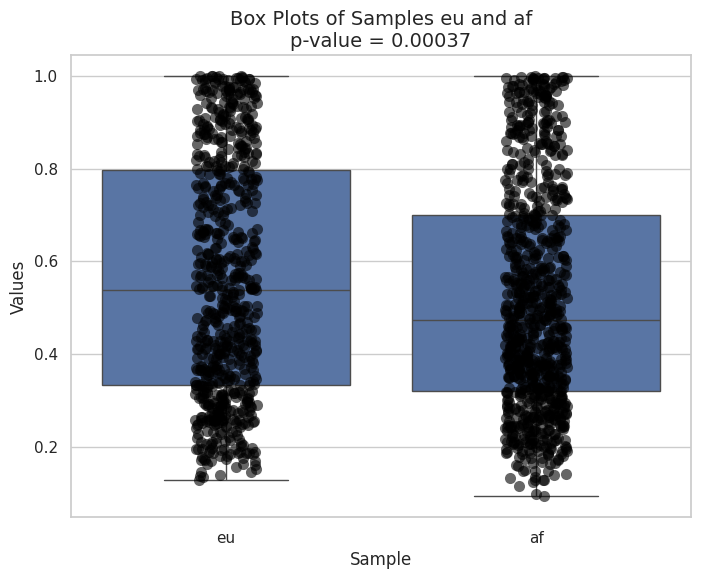

In [32]:
def plot_samples_with_pvalue(x1, x2, test_fn, name1, name2):
    # Perform the statistical test
    test_statistic, p_value = test_fn(x1, x2)
    
    # Create a DataFrame for plotting
    data = {
        'Sample': [name1] * len(x1) + [name2] * len(x2),
        'Values': np.concatenate([x1, x2])
    }
    
    # Create the box plots
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Sample', y='Values', data=data)
    
    # Overlay individual data points using stripplot
    sns.stripplot(x='Sample', y='Values', data=data, color='black', jitter=True, size=8, alpha=0.6)
    
    # Add the p-value to the title
    plt.title(f'Box Plots of Samples {name1} and {name2}\np-value = {p_value:.5f}', fontsize=14)
    
    # Display the plot
    plt.show()


plot_samples_with_pvalue(confidences['eu'], confidences['af'], test_fn, 'eu', 'af')
